In [20]:
# Neural Networks
# Needed libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.neural_network import MLPRegressor

In [21]:
# Takes the csv file and converts it into a dataframe
df = pd.read_csv('/Users/dimitrishort/Documents/DataMiningFinal/ProcessedMovieData.csv')

# Displays the first few rows of the dataframe 
df.head()

,userId,movieId,rating,title,genres,datetime,year,month,day,dayofweek,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year
0,1,1,0.777778,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,2000-07-30 18:45:03,2000,7,30,6,...,0,0,0,0,0,0,0,0,0,1995.0
1,5,1,0.777778,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1996-11-08 06:36:02,1996,11,8,4,...,0,0,0,0,0,0,0,0,0,1995.0
2,7,1,0.888889,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,2005-01-25 06:52:26,2005,1,25,1,...,0,0,0,0,0,0,0,0,0,1995.0
3,15,1,0.444444,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,2017-11-13 12:59:30,2017,11,13,0,...,0,0,0,0,0,0,0,0,0,1995.0
4,17,1,0.888889,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,2011-05-18 05:28:03,2011,5,18,2,...,0,0,0,0,0,0,0,0,0,1995.0


In [22]:
# Drops columns that aren't needed for the model 
X = df.drop(['userId', 'movieId', 'rating', 'title', 'genres', 'datetime', 'release_year'], axis=1)
y = df['rating'] # Sets the target to rating for the model 

# Splits the dataset into training and test sets with 20% for testing and 80% for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Defines list of different configs of neurons and layers  
neurons_range = [
    (5,),         # 1 hidden layer with 5 neurons
    (3, 2),       # 2 hidden layers with 3 neurons and, 2 neurons 
    (2, 5, 2)]    # 3 hidden layers with 2 neurons, 5 neurons, and 2 neurons 

models = [] # List to store the model
train_errors = [] # List to store the training errors 
test_errors = [] # List to store the testing errors 

# Loops through each configuration of neurons
for neurons in neurons_range:
    # Initializes MLPRegressor with current config with iterations and rand. state
    mlp = MLPRegressor(hidden_layer_sizes=neurons, max_iter=1000, random_state=1)
    mlp.fit(X_train, y_train) # Fits the model to the training data
    models.append(mlp) # Stores the trained model 
    
    y_train_pred = mlp.predict(X_train) # Predicts on the training data calculating the MSE 
    y_test_pred = mlp.predict(X_test) # Predicts on the testing data calculating the MSE 
    
    train_errors.append(mse(y_train, y_train_pred)) # Calculates MSE for training predictions
    test_errors.append(mse(y_test, y_test_pred)) # Calculates MSE for test predictions

# Finds the model with the lowest test error
best_model_index = test_errors.index(min(test_errors))
best_model = models[best_model_index] # Selects the best model based on the test error 


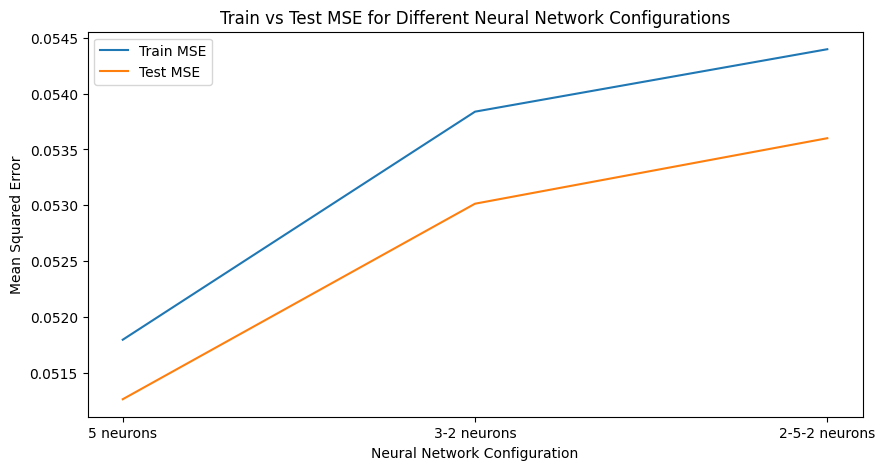

In [24]:
# Plots the relationship between the neuron configuration and the MSE 
plt.figure(figsize=(10, 5))
plt.plot(['5 neurons', '3-2 neurons', '2-5-2 neurons'], train_errors, label='Train MSE')
plt.plot(['5 neurons', '3-2 neurons', '2-5-2 neurons'], test_errors, label='Test MSE')
plt.xlabel('Neural Network Configuration')
plt.ylabel('Mean Squared Error')
plt.title('Train vs Test MSE for Different Neural Network Configurations')
plt.legend()
plt.show()

In [25]:
def recommend_movies_for_user_nn(user_id, model, data, num_recommendations=5):
    # Gets the movies that the user already rated 
    rated_movies = data[data['userId'] == user_id]['movieId'].unique()
    
    # Gets the movies that haven't been rated by the user 
    unrated_movies = data[~data['movieId'].isin(rated_movies)].drop_duplicates('movieId')
    
    # Prepares the data for the unrated movies by dropping unnecessary columns
    features = unrated_movies.drop(['userId', 'movieId', 'rating', 'title', 'genres', 'datetime', 'release_year'], axis=1)
    
    # Predicts ratings for the unrated movies from the trained model 
    unrated_movies['predicted_rating'] = model.predict(features)
    
    # Get the top 5 recommendations based on predicted ratings in descending order 
    predicted_ratings = unrated_movies.nlargest(num_recommendations, 'predicted_rating')
    
    # Returns the recommended movies 
    return predicted_ratings[['title', 'genres', 'predicted_rating']]

# Calls the function to get the predicted movies with a given user 
recommended_movies = recommend_movies_for_user_nn(user_id=1, model=best_model, data=df, num_recommendations=5)
print(recommended_movies) # Prints the recommended movies

                                                    title  \
73807                  Waltz with Bashir (Vals im Bashir)   
100183  Patlabor: The Movie (Kidô keisatsu patorebâ: T...   
96803                  Night and Fog (Nuit et brouillard)   
70189                                        Lost Highway   
93126                                          White Heat   

                                                   genres  predicted_rating  
73807                     Animation|Documentary|Drama|War          0.841206  
100183  Action|Animation|Crime|Drama|Film-Noir|Mystery...          0.838402  
96803                               Crime|Documentary|War          0.810837  
70189       Crime|Drama|Fantasy|Film-Noir|Mystery|Romance          0.802615  
93126                               Crime|Drama|Film-Noir          0.801359  


In [26]:
'''
Using neural networks to produce movie recommendations does tend
to give accurate recommendations. This is seen through the genres
being recommended such as Drama, Crime, and Animation which the 
user tends to prefer. It also includes some genres such as Documentary, 
and Film-Noir which aren't highly rated by the user but are mixed with 
other genres the user prefers. This could produce a greater reach and 
suggest new genres for the user that they may enjoy. It can still be 
improved however as genres the user prefers Adventure and Comedy aren't
listed in the recommendations. Overall, the model does give accurate 
recommendations based on the user preferences but can still be improved. 
'''

"\nUsing neural networks to produce movie recommendations does tend\nto give accurate recommendations. This is seen through the genres\nbeing recommended such as Drama, Crime, and Animation which the \nuser tends to prefer. It also includes some genres such as Documentary, \nand Film-Noir which aren't highly rated by the user but are mixed with \nother genres the user prefers. This could produce a greater reach and \nsuggest new genres for the user that they may enjoy. It can still be \nimproved however as genres the user prefers Adventure and Comedy aren't\nlisted in the recommendations. Overall, the model does give accurate \nrecommendations based on the user preferences but can still be improved. \n"